In [287]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [289]:
path = 'bank_customer.csv'
df = pd.read_csv(path)

In [291]:
df.head()

,Unnamed: 0,ID,Gender,Month_Income,Age,Region_Code,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,0,VBENBARO,Male,96345.0,29,254,Other,623,Yes,4,742366,X1,2,No
1,1,CCMEWNKY,Male,85640.0,43,268,Other,629,NaN,0,925537,X2,1,No
2,2,VK3KGA9M,Male,96345.0,31,270,Salaried,357,No,0,215949,X1,1,No
3,3,TT8RPZVC,Male,85640.0,29,272,Other,356,No,0,868070,X1,3,No
4,4,SHQZEYTZ,Female,42820.0,29,270,Other,572,No,0,657087,X1,3,No


In [293]:
# Select categorical columns

categorical_columns = df.select_dtypes(include=['object']).columns.to_list()
categorical_columns

['ID',
 'Gender',
 'Occupation',
 'Loan_Status',
 'Account_Category',
 'Lead_Outcome']

In [295]:
# Select numerical columns

numerical_columns = df.select_dtypes(include=['float64','int64']).columns.to_list()
numerical_columns


['Unnamed: 0',
 'Month_Income',
 'Age',
 'Region_Code',
 'Credit_Score',
 'Existing_Credit_Cards',
 'Avg_Account_Balance',
 'Tenure_with_Bank']

In [297]:
# Check for duplicated values

df.duplicated().sum()

0

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             105000 non-null  int64  
 1   ID                     105000 non-null  object 
 2   Gender                 105000 non-null  object 
 3   Month_Income           102514 non-null  float64
 4   Age                    105000 non-null  int64  
 5   Region_Code            105000 non-null  int64  
 6   Occupation             102486 non-null  object 
 7   Credit_Score           105000 non-null  int64  
 8   Loan_Status            92511 non-null   object 
 9   Existing_Credit_Cards  105000 non-null  int64  
 10  Avg_Account_Balance    105000 non-null  int64  
 11  Account_Category       105000 non-null  object 
 12  Tenure_with_Bank       105000 non-null  int64  
 13  Lead_Outcome           105000 non-null  object 
dtypes: float64(1), int64(7), object(6)
m

In [301]:
# Check for missing values

print(df.isnull().sum())

Unnamed: 0                   0
ID                           0
Gender                       0
Month_Income              2486
Age                          0
Region_Code                  0
Occupation                2514
Credit_Score                 0
Loan_Status              12489
Existing_Credit_Cards        0
Avg_Account_Balance          0
Account_Category             0
Tenure_with_Bank             0
Lead_Outcome                 0
dtype: int64


In [303]:
# Filter missing values

missing_values = df.isna().sum().to_dict()

columns_with_missing_values = {m: n for m, n in missing_values.items() if n > 0}

column_data_types = df.dtypes.to_dict()

numerical_missing_values = {m: n for m, n in columns_with_missing_values.items() if column_data_types[m] in ['int64', 'float64']}
categorical_missing_values = {m: n for m, n in columns_with_missing_values.items() if column_data_types[m] == 'object'}

print("Numerical columns with missing values:", numerical_missing_values)
print("Categorical columns with missing values:", categorical_missing_values)

Numerical columns with missing values: {'Month_Income': 2486}
Categorical columns with missing values: {'Occupation': 2514, 'Loan_Status': 12489}


In [305]:
# Fill the categorical missing values to mode

for column in categorical_missing_values:
    if df[column].isnull().any():
        df[column] = df[column].fillna(df[column].mode()[0])

In [307]:
# Fill the numerical missing values to mean

for column in numerical_missing_values:
    if df[column].isnull().any():
        df[column] = df[column].fillna(df[column].mean())

In [309]:
# Check for missing values

print(df.isnull().sum())

Unnamed: 0               0
ID                       0
Gender                   0
Month_Income             0
Age                      0
Region_Code              0
Occupation               0
Credit_Score             0
Loan_Status              0
Existing_Credit_Cards    0
Avg_Account_Balance      0
Account_Category         0
Tenure_with_Bank         0
Lead_Outcome             0
dtype: int64


In [311]:
# Drop the unnecessary columns

df = df.drop(['Unnamed: 0','ID', 'Region_Code'], axis=1)

In [313]:
df.head()

,Gender,Month_Income,Age,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,Male,96345.0,29,Other,623,Yes,4,742366,X1,2,No
1,Male,85640.0,43,Other,629,No,0,925537,X2,1,No
2,Male,96345.0,31,Salaried,357,No,0,215949,X1,1,No
3,Male,85640.0,29,Other,356,No,0,868070,X1,3,No
4,Female,42820.0,29,Other,572,No,0,657087,X1,3,No


In [315]:
#Check the outliers

def check_outliers(dataset):
    outliers = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        outliers[column] = outliers_column[column]
        
        print(f"Column: {column}")
        print(f"Number of outliers in {column}: {len(outliers_column)}")
        print("\n")
        
    return outliers

outliers = check_outliers(df)

Column: Month_Income
Number of outliers in Month_Income: 5904


Column: Age
Number of outliers in Age: 0


Column: Credit_Score
Number of outliers in Credit_Score: 0


Column: Existing_Credit_Cards
Number of outliers in Existing_Credit_Cards: 8600


Column: Avg_Account_Balance
Number of outliers in Avg_Account_Balance: 6197


Column: Tenure_with_Bank
Number of outliers in Tenure_with_Bank: 0




In [317]:
import matplotlib.pyplot as plt
import seaborn as sns

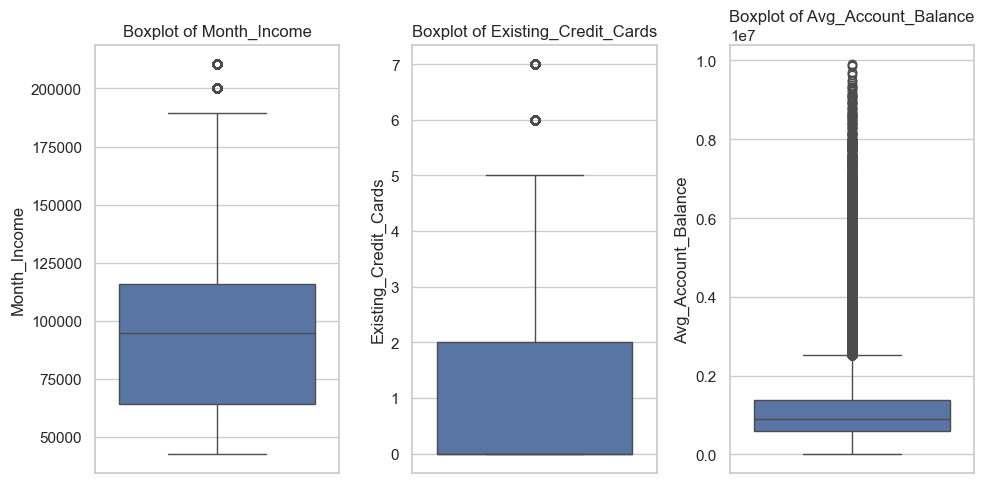

In [319]:
columns_with_outliers = ['Month_Income', 'Existing_Credit_Cards', 'Avg_Account_Balance']

plt.figure(figsize=(10, 5))

for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(1, len(columns_with_outliers), i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    
plt.tight_layout()
plt.show()

In [321]:
# handling Tenure_with_Bank

def categorize_tenure(value):
    if value in [1, 2, 3, 4]:
        return value
    elif value >= 5 and value <10:
        return 5        #'5-10'
    elif value >= 10:
        return 6        #'10+'

# Apply the function to create a new column with categorized values
df['Tenure_with_Bank_Categorized'] = df['Tenure_with_Bank'].apply(categorize_tenure)

# Update the original column with the new categorized values
df['Tenure_with_Bank'] = df['Tenure_with_Bank_Categorized']

# Drop the temporary column
df.drop(columns=['Tenure_with_Bank_Categorized'], inplace=True)

print(df['Tenure_with_Bank'].value_counts())

Tenure_with_Bank
5    31506
6    22530
2    12796
1    12754
3    12747
4    12667
Name: count, dtype: int64


In [323]:
# handling Existing_Credit_Cards
df['Existing_Credit_Cards'] = df['Existing_Credit_Cards'].apply(lambda x: 0 if x == 0 else 1)

print(df['Existing_Credit_Cards'].value_counts())

Existing_Credit_Cards
0    73920
1    31080
Name: count, dtype: int64


In [325]:
sns.set(style="whitegrid")

# Function to plot distributions
def plot_distribution(column):
    plt.figure(figsize=(10, 5))
    if df[column].dtype == 'object':
        sns.countplot(x=column, data=df, palette='viridis')
        plt.title(f'Distribution of {column}')
    else:
        sns.histplot( df[column], bins=30, kde=True, color='skyblue')
        plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


# Function to plot count plot by target
def plot_by_target(column, target_column='Lead_Outcome'):
    plt.figure(figsize=(10, 5))
    if df[column].dtype == 'object':
        sns.countplot(x=column, hue=target_column, data=df, palette='Set2')
        plt.title(f'{column} Distribution by {target_column}')
    else:
        sns.boxplot(x=target_column, y=column, data=df, palette='Set2')
        plt.title(f'{column} Distribution by {target_column}')
    plt.xlabel(column)
    plt.ylabel('Count' if df[column].dtype == 'object' else column)
    plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_12420\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


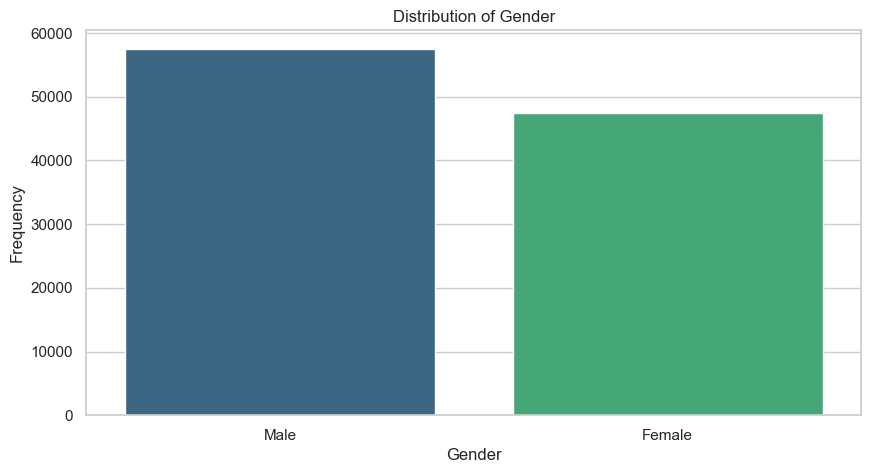

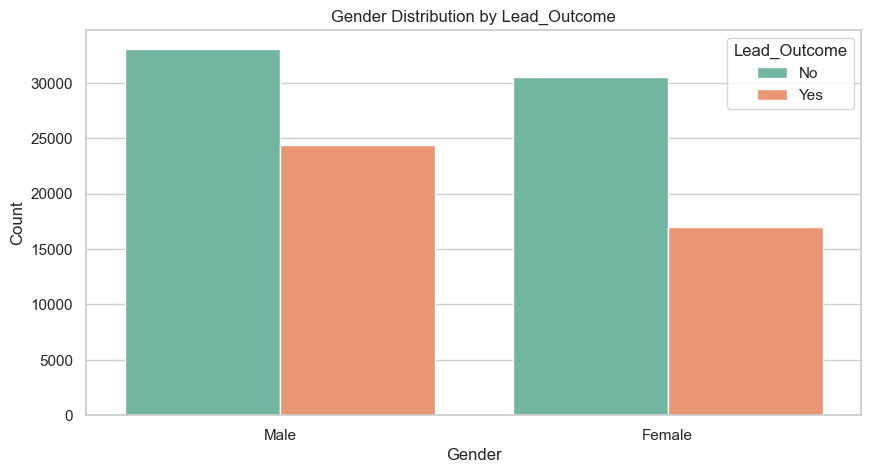

In [327]:
plot_distribution('Gender')
plot_by_target('Gender')

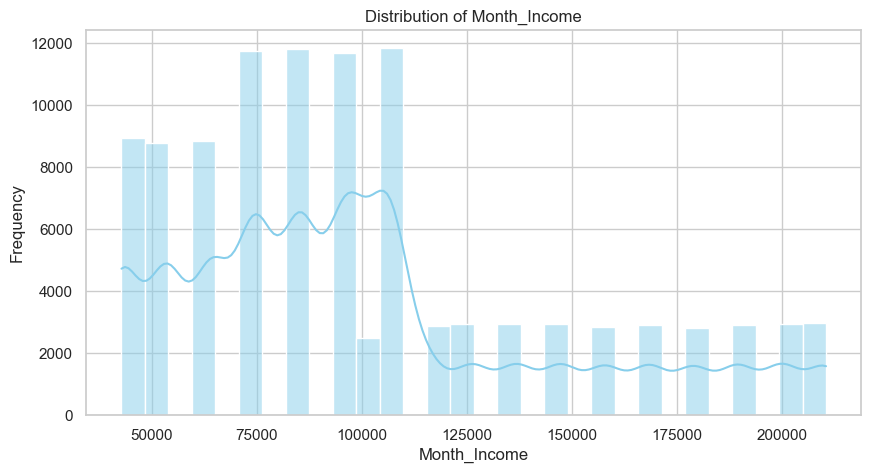

C:\Users\Dell\AppData\Local\Temp\ipykernel_12420\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


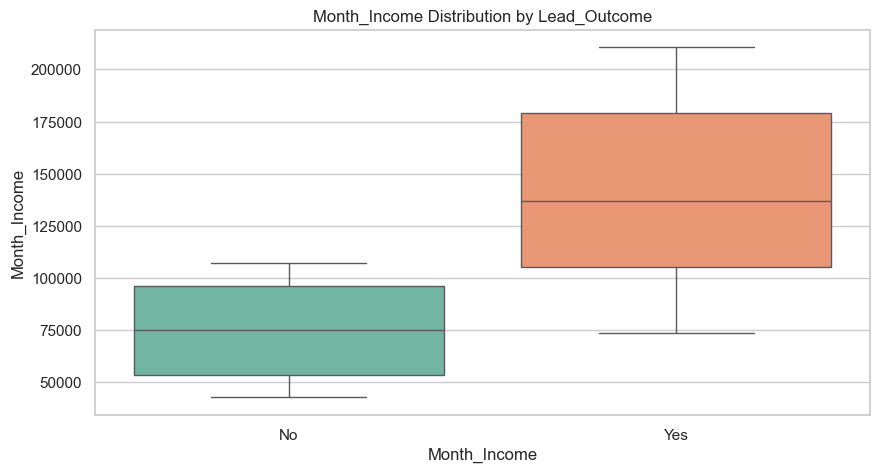

In [329]:
plot_distribution('Month_Income')
plot_by_target('Month_Income')

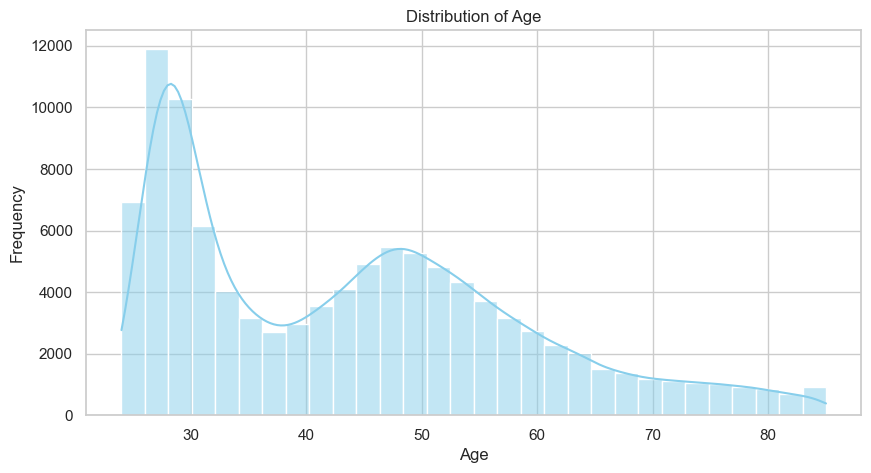

C:\Users\Dell\AppData\Local\Temp\ipykernel_12420\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


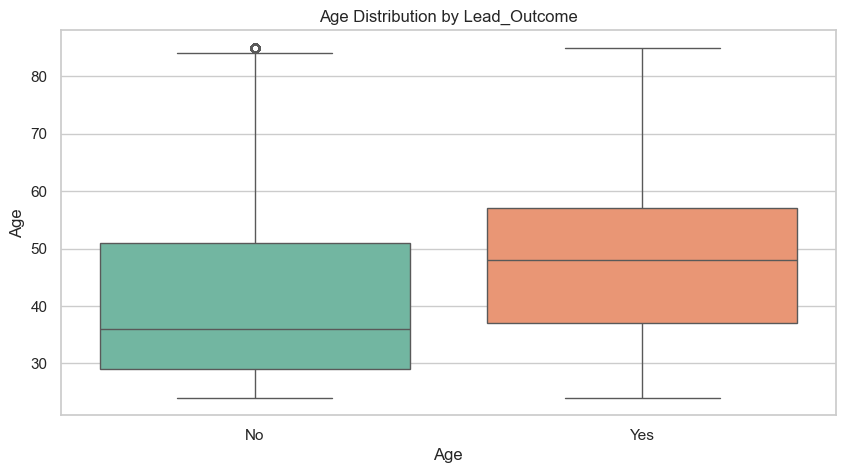

In [331]:
plot_distribution('Age')
plot_by_target('Age')

C:\Users\Dell\AppData\Local\Temp\ipykernel_12420\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


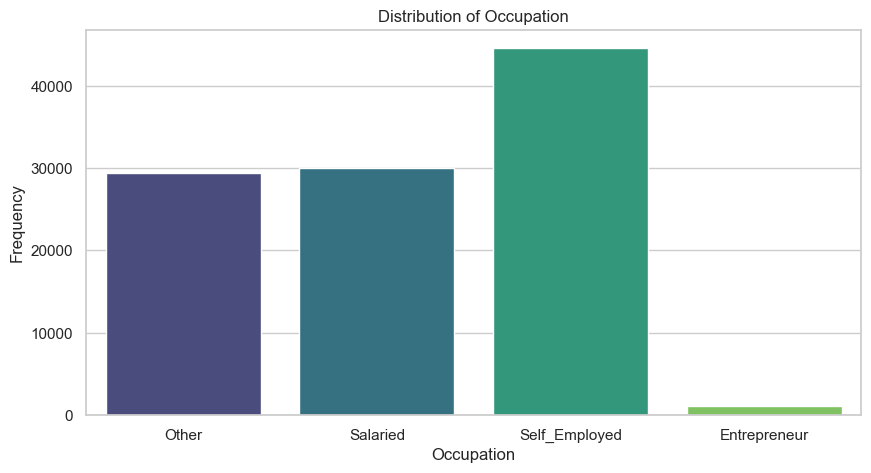

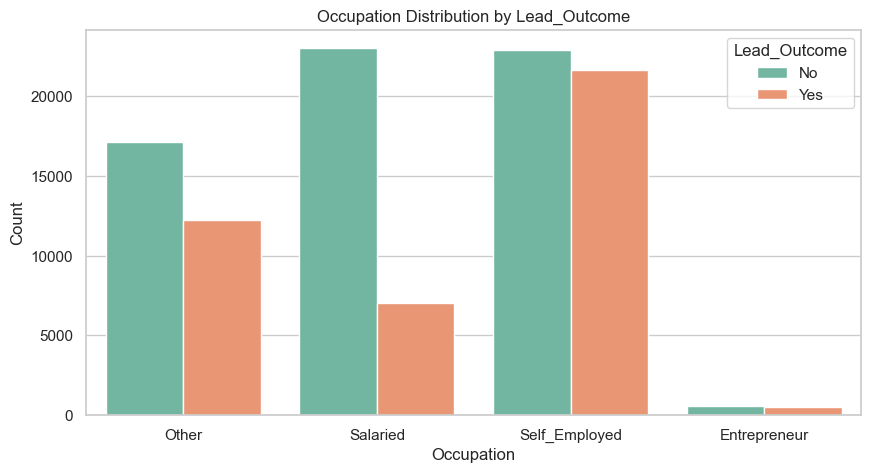

In [333]:
plot_distribution('Occupation')
plot_by_target('Occupation')

C:\Users\Dell\AppData\Local\Temp\ipykernel_12420\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


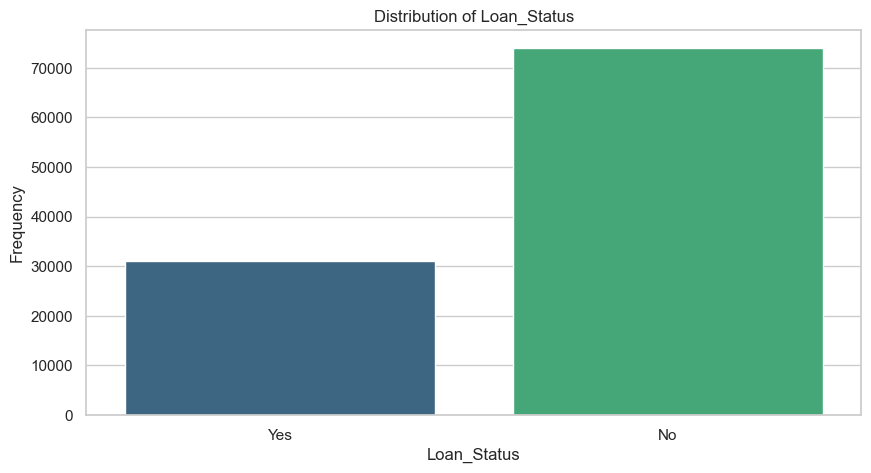

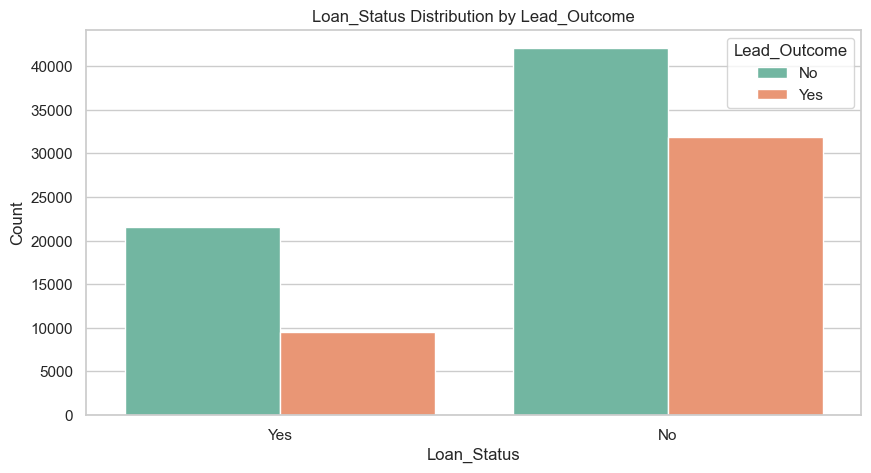

In [335]:
plot_distribution('Loan_Status')
plot_by_target('Loan_Status')

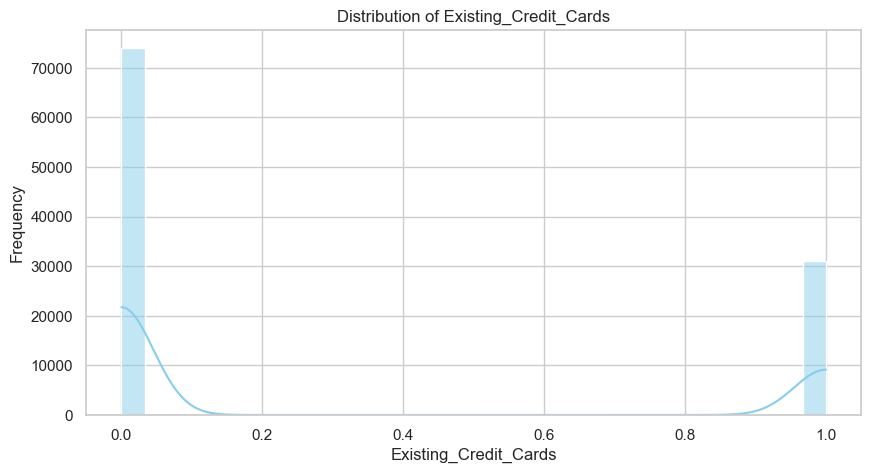

C:\Users\Dell\AppData\Local\Temp\ipykernel_12420\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


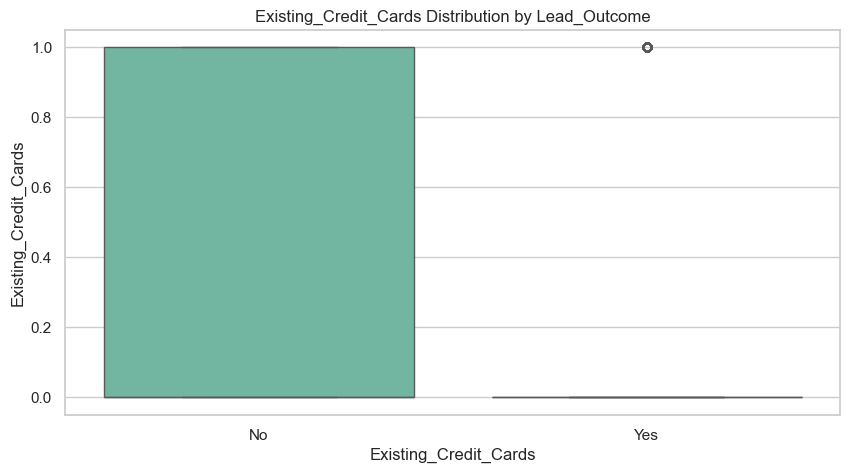

In [337]:
plot_distribution('Existing_Credit_Cards')
plot_by_target('Existing_Credit_Cards')

C:\Users\Dell\AppData\Local\Temp\ipykernel_12420\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


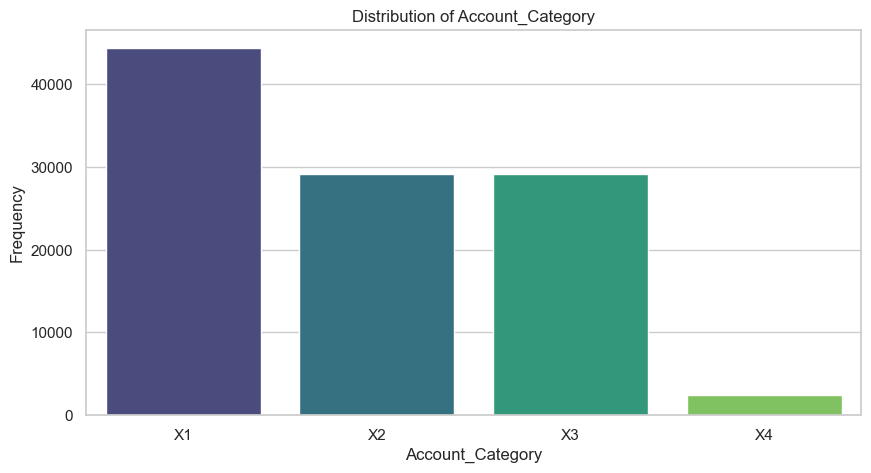

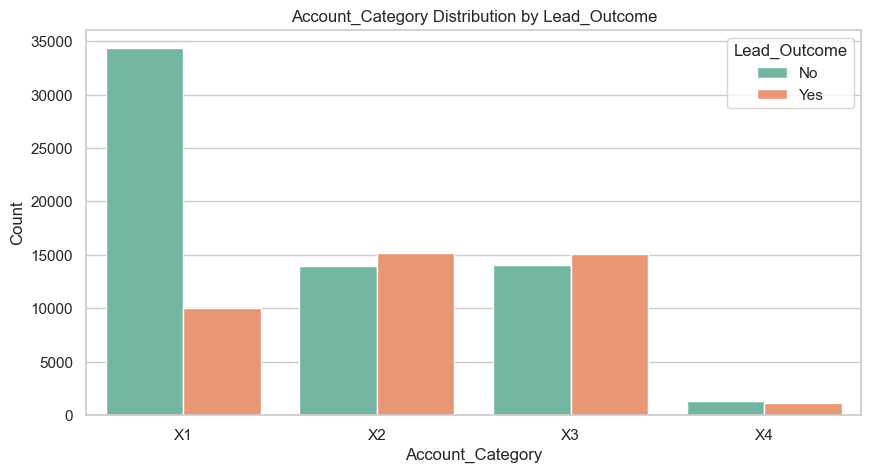

In [339]:
plot_distribution('Account_Category')
plot_by_target('Account_Category')

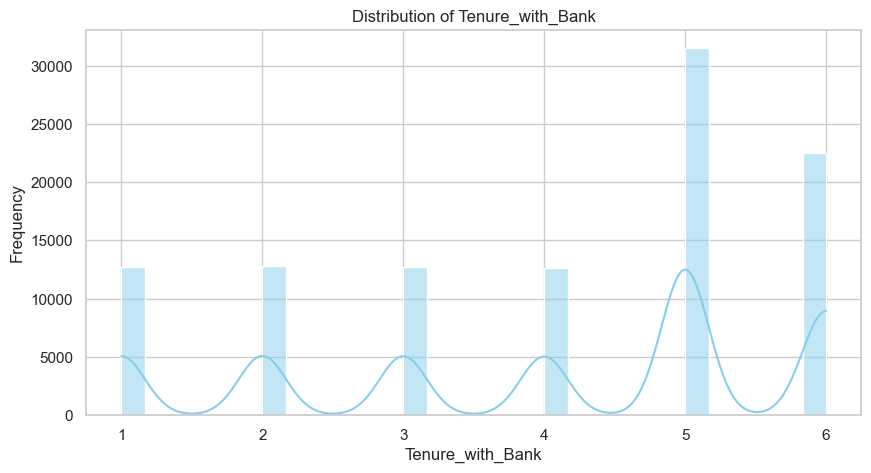

C:\Users\Dell\AppData\Local\Temp\ipykernel_12420\3294662204.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_column, y=column, data=df, palette='Set2')


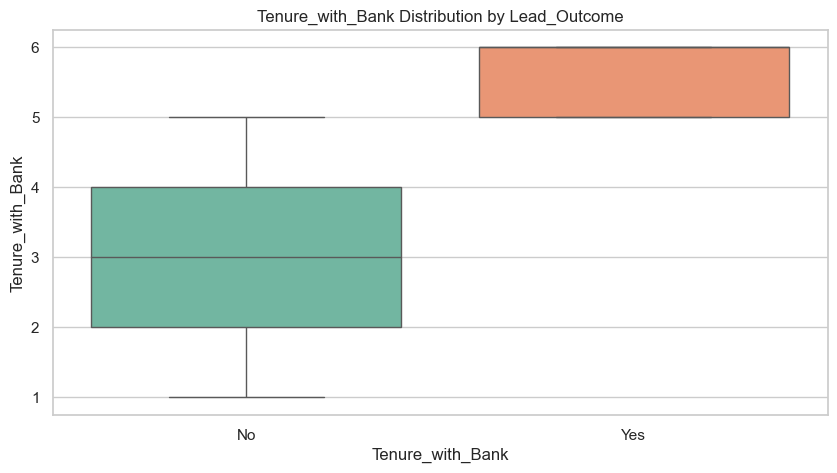

In [341]:
plot_distribution('Tenure_with_Bank')
plot_by_target('Tenure_with_Bank')

C:\Users\Dell\AppData\Local\Temp\ipykernel_12420\3294662204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette='viridis')


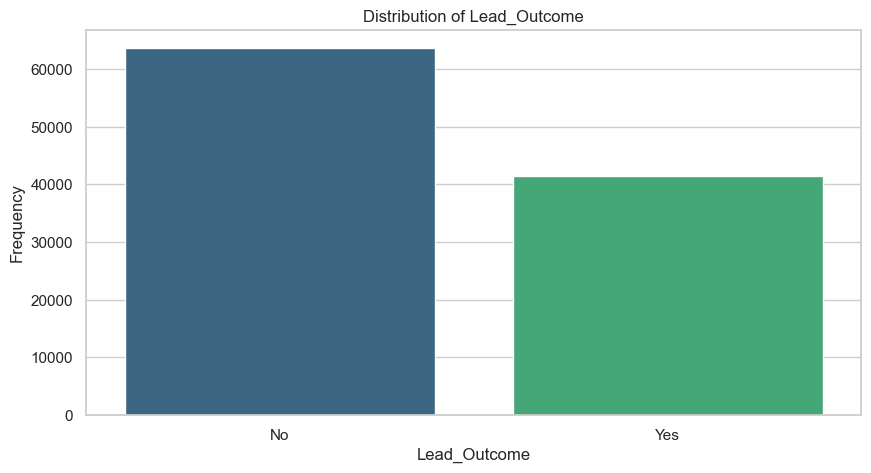

In [343]:
plot_distribution('Lead_Outcome')

In [345]:
# Encode categorical features
label_encoder = LabelEncoder()

# Encoding categorical columns (Gender, Loan_Status, Account_Category, Lead_Outcome)
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Loan_Status'] = label_encoder.fit_transform(df['Loan_Status'])
df['Account_Category'] = label_encoder.fit_transform(df['Account_Category'])
df['Occupation'] = label_encoder.fit_transform(df['Occupation'])

df['Lead_Outcome']=df['Lead_Outcome'].apply(lambda x : 1 if x=='Yes' else 0) 

# Separate features (X) and target variable (Y)
X = df.drop(columns=['Lead_Outcome'])
Y = df['Lead_Outcome']

In [347]:
df.head()

,Gender,Month_Income,Age,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,1,96345.0,29,1,623,1,1,742366,0,2,0
1,1,85640.0,43,1,629,0,0,925537,1,1,0
2,1,96345.0,31,2,357,0,0,215949,0,1,0
3,1,85640.0,29,1,356,0,0,868070,0,3,0
4,0,42820.0,29,1,572,0,0,657087,0,3,0


In [349]:
# Separate features (X) and target variable (Y)

X = df.drop(columns=['Lead_Outcome'])
Y = df['Lead_Outcome']

In [351]:
X

,Gender,Month_Income,Age,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank
0,1,96345.0,29,1,623,1,1,742366,0,2
1,1,85640.0,43,1,629,0,0,925537,1,1
2,1,96345.0,31,2,357,0,0,215949,0,1
3,1,85640.0,29,1,356,0,0,868070,0,3
4,0,42820.0,29,1,572,0,0,657087,0,3
...,...,...,...,...,...,...,...,...,...,...
104995,1,53525.0,27,3,364,1,1,1168792,0,2
104996,1,74935.0,55,3,400,1,1,6150086,1,2
104997,0,53525.0,31,3,502,0,0,743897,0,4
104998,1,157875.0,47,3,824,1,1,1918608,2,5


In [353]:
Y

0         0
1         0
2         0
3         0
4         0
         ..
104995    0
104996    0
104997    0
104998    1
104999    1
Name: Lead_Outcome, Length: 105000, dtype: int64

In [355]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Standardize the features (important for Lasso)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [357]:
# Create and train the Lasso regression model

lasso_model = Lasso(alpha=0.1)  # You can adjust the alpha value (regularization strength)
lasso_model.fit(X_train, Y_train)

# Make predictions
Y_pred = lasso_model.predict(X_test)

In [359]:
r2 = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

print(f'R² Score: {r2}')
print(f'Mean Squared Error: {mse}')
print(f"Mean Absolute Error: {mae}")

print(f'Coefficients: {lasso_model.coef_}')

R² Score: 0.7907663516684023
Mean Squared Error: 0.049968714720021325
Mean Absolute Error: 0.19162994009000195
Coefficients: [ 0.          0.05812525  0.          0.          0.24730091 -0.
 -0.          0.          0.          0.06960986]


In [361]:
import joblib
from joblib import dump, load

# Save the model
dump(lasso_model, 'credit_card_lead_prediction_model.joblib')

['credit_card_lead_prediction_model.joblib']